In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from tqdm.notebook import tqdm
from pathlib import Path
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


# Načítání dat

In [5]:
data = pd.read_csv("C:/Users/matej/Desktop/MFF UK/8. semester/Data Science 2/Zadanie 1/2024_DS2_HW1_data_train.csv", sep = ',', decimal = '.', index_col = 'Booking_ID')
data_test = pd.read_csv("C:/Users/matej/Desktop/MFF UK/8. semester/Data Science 2/Zadanie 1/2024_DS2_HW1_data_train.csv", sep = ',', decimal = '.', index_col = 'Booking_ID')

In [6]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

In [44]:
data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN16851,2.0,NaN,NaN,NaN,Meal Plan 1,NaN,NaN,43.0,2017.0,12.0,26.0,Offline,NaN,0.0,0.0,NaN,2.0,0.0
INN06266,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,102.0,2017.0,10.0,NaN,Online,NaN,0.0,NaN,80.0,NaN,1.0
INN11285,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2018.0,5.0,NaN,Corporate,0.0,0.0,0.0,NaN,1.0,0.0


# Outlook at the data

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32647 entries, INN10204 to INN15796
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          28231 non-null  float64
 1   no_of_children                        5043 non-null   float64
 2   no_of_weekend_nights                  7729 non-null   float64
 3   no_of_week_nights                     24287 non-null  float64
 4   type_of_meal_plan                     16544 non-null  object 
 5   required_car_parking_space            17863 non-null  float64
 6   room_type_reserved                    11360 non-null  object 
 7   lead_time                             6935 non-null   float64
 8   arrival_year                          29654 non-null  float64
 9   arrival_month                         31740 non-null  float64
 10  arrival_date                          5457 non-null   float64
 11  market_seg

In [46]:
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


In [7]:
data.rename(columns = {'booking_status':'TARGET'}, inplace = True) 
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,TARGET
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [8]:
col_target = "TARGET"
col_month = "arrival_month"

In [9]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan      object
room_type_reserved     object
market_segment_type    object
dtype: object


In [10]:
len(cols_pred)

17

In [11]:
data.TARGET.value_counts(dropna=False)

TARGET
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [12]:
data = data.dropna(subset=["TARGET"])

In [13]:
data.drop(data.loc[:,list((100*(data.isnull().sum()/len(data.index))>98))].columns)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,TARGET
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN16851,2.0,NaN,NaN,NaN,Meal Plan 1,NaN,NaN,43.0,2017.0,12.0,26.0,Offline,NaN,0.0,0.0,NaN,2.0,0.0
INN06266,1.0,NaN,NaN,2.0,Meal Plan 2,0.0,Room_Type 1,102.0,2017.0,10.0,NaN,Online,NaN,0.0,NaN,80.0,NaN,1.0
INN11285,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2018.0,5.0,NaN,Corporate,0.0,0.0,0.0,NaN,1.0,0.0


In [14]:
data['sample'] = 'default'

# use train_test_split to split the intime into train and rest (don't forget seed)
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 12)
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed)
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12)
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

In [15]:
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 1])
    plt.ylabel('default rate', loc='top')
    plt.xlabel('month', loc='right')
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray') 
    
    plt.show()

# Plotting the cancellations per month

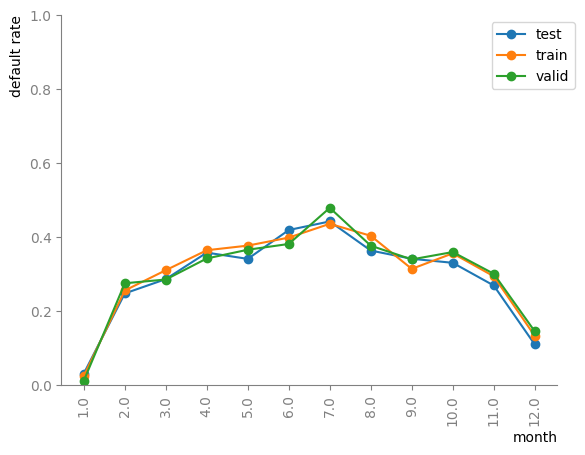

In [16]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

In [17]:
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test')

In [18]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

In [19]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [20]:
# replace infinity values
for col in cols_with_inf:
    data[col] = data[col].replace(np.inf, 9999999)

In [21]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [22]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

In [24]:
data.required_car_parking_space.value_counts(dropna=False)

required_car_parking_space
0.0    17077
NaN    14621
1.0      597
Name: count, dtype: int64

In [25]:
data.repeated_guest.value_counts(dropna=False)

repeated_guest
NaN    24715
0.0     7383
1.0      197
Name: count, dtype: int64

In [26]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.70896	test-auc:0.71244	valid-auc:0.70086
[1]	train-auc:0.74298	test-auc:0.74382	valid-auc:0.73440
[2]	train-auc:0.75825	test-auc:0.75907	valid-auc:0.75413
[3]	train-auc:0.76795	test-auc:0.77046	valid-auc:0.76318
[4]	train-auc:0.77516	test-auc:0.77692	valid-auc:0.76882
[5]	train-auc:0.78349	test-auc:0.78528	valid-auc:0.77789
[6]	train-auc:0.78574	test-auc:0.78728	valid-auc:0.77990
[7]	train-auc:0.78985	test-auc:0.79130	valid-auc:0.78316
[8]	train-auc:0.79269	test-auc:0.79336	valid-auc:0.78575
[9]	train-auc:0.79447	test-auc:0.79498	valid-auc:0.78778
[10]	train-auc:0.79750	test-auc:0.79663	valid-auc:0.79025
[11]	train-auc:0.79762	test-auc:0.79673	valid-auc:0.79081
[12]	train-auc:0.79944	test-auc:0.79802	valid-auc:0.79232
[13]	train-auc:0.80143	test-auc:0.79915	valid-auc:0.79384
[14]	train-auc:0.80237	test-auc:0.80022	valid-auc:0.79477
[15]	train-auc:0.80329	test-auc:0.80071	valid-auc:0.79550
[16]	train-auc:0.80405	test-auc:0.80099	valid-auc:0.79581
[17]	train-auc:0.80519	t

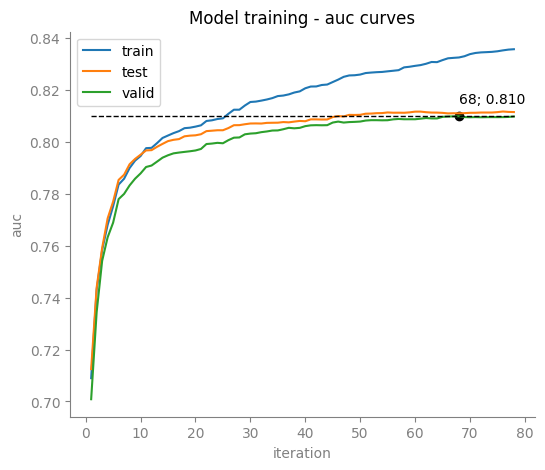

In [27]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

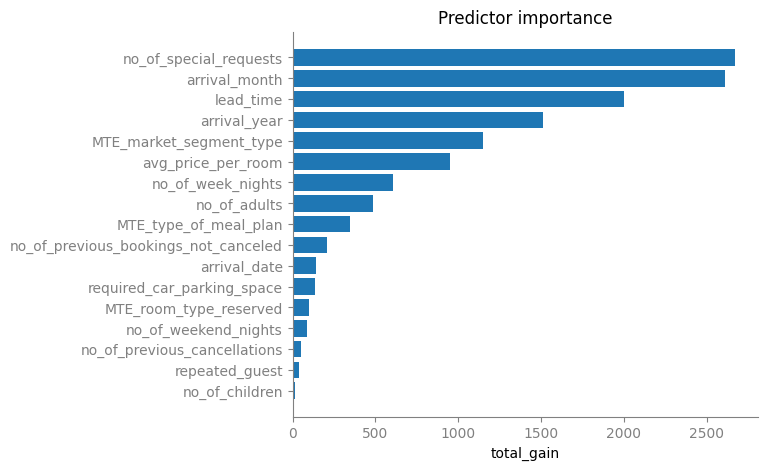

In [28]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 17
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:20])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:20])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

In [29]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=12,
    verbosity=1,
    eval_metric='auc',
    use_label_encoder=False,
    early_stopping_rounds=10,
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)

[0]	validation_0-auc:0.75533	validation_1-auc:0.75971	validation_2-auc:0.74696
[1]	validation_0-auc:0.77571	validation_1-auc:0.77279	validation_2-auc:0.76644
[2]	validation_0-auc:0.78522	validation_1-auc:0.78015	validation_2-auc:0.77605
[3]	validation_0-auc:0.78980	validation_1-auc:0.78418	validation_2-auc:0.77833
[4]	validation_0-auc:0.79962	validation_1-auc:0.79262	validation_2-auc:0.78682
[5]	validation_0-auc:0.80282	validation_1-auc:0.79481	validation_2-auc:0.78939
[6]	validation_0-auc:0.80481	validation_1-auc:0.79667	validation_2-auc:0.79193
[7]	validation_0-auc:0.81011	validation_1-auc:0.80134	validation_2-auc:0.79579
[8]	validation_0-auc:0.81493	validation_1-auc:0.80348	validation_2-auc:0.79984
[9]	validation_0-auc:0.81595	validation_1-auc:0.80412	validation_2-auc:0.80091
[10]	validation_0-auc:0.81699	validation_1-auc:0.80486	validation_2-auc:0.80160
[11]	validation_0-auc:0.82035	validation_1-auc:0.80779	validation_2-auc:0.80555
[12]	validation_0-auc:0.82185	validation_1-auc:0.8

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=12, ...)

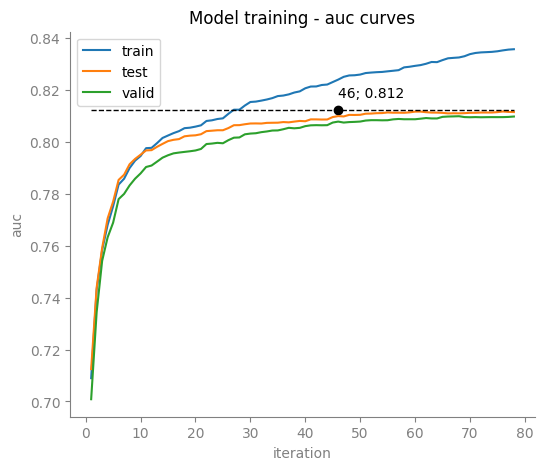

In [30]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster_sklearn.best_score
best_iteration = booster_sklearn.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

In [36]:
params={
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = data[col_target].values
data['cv_score'] = -1
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]

    data.iloc[test_index, list(data.columns).index('cv_score')] = None
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

[0]	train-auc:0.68184	test-auc:0.68659
[1]	train-auc:0.69771	test-auc:0.69836
[2]	train-auc:0.73741	test-auc:0.73900
[3]	train-auc:0.73544	test-auc:0.73710
[4]	train-auc:0.74288	test-auc:0.74366
[5]	train-auc:0.75457	test-auc:0.75406
[6]	train-auc:0.75583	test-auc:0.75519
[7]	train-auc:0.76316	test-auc:0.76119
[8]	train-auc:0.76842	test-auc:0.76640
[9]	train-auc:0.76824	test-auc:0.76558
[10]	train-auc:0.76977	test-auc:0.76705
[11]	train-auc:0.76959	test-auc:0.76586
[12]	train-auc:0.76939	test-auc:0.76579
[13]	train-auc:0.77136	test-auc:0.76810
[14]	train-auc:0.77275	test-auc:0.76952
[15]	train-auc:0.77463	test-auc:0.77130
[16]	train-auc:0.77664	test-auc:0.77294
[17]	train-auc:0.77668	test-auc:0.77322
[18]	train-auc:0.77782	test-auc:0.77448
[19]	train-auc:0.77702	test-auc:0.77346
[20]	train-auc:0.77758	test-auc:0.77358
[21]	train-auc:0.77722	test-auc:0.77368
[22]	train-auc:0.77834	test-auc:0.77490
[23]	train-auc:0.78109	test-auc:0.77732
[24]	train-auc:0.78122	test-auc:0.77764
[25]	train

In [32]:
cv_res

[(0.655230607823682, 0.6092168818884154, 245),
 (0.6745235005339973, 0.6113830252776449, 357)]

In [33]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

Cross validation score performance: 0.6104


In [34]:
roc_auc_score(data[col_target], data['cv_score'])

0.8051871256066337

In [35]:
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

[0]	train-auc:0.68319
[1]	train-auc:0.72357
[2]	train-auc:0.74129
[3]	train-auc:0.73985
[4]	train-auc:0.74000
[5]	train-auc:0.73952
[6]	train-auc:0.74883
[7]	train-auc:0.76306
[8]	train-auc:0.76642
[9]	train-auc:0.76719
[10]	train-auc:0.76662
[11]	train-auc:0.76586
[12]	train-auc:0.76781
[13]	train-auc:0.77193
[14]	train-auc:0.77365
[15]	train-auc:0.77449
[16]	train-auc:0.77552
[17]	train-auc:0.77617
[18]	train-auc:0.77730
[19]	train-auc:0.77785
[20]	train-auc:0.77764
[21]	train-auc:0.77875
[22]	train-auc:0.77916
[23]	train-auc:0.78006
[24]	train-auc:0.78030
[25]	train-auc:0.78166
[26]	train-auc:0.78196
[27]	train-auc:0.78270
[28]	train-auc:0.78319
[29]	train-auc:0.78370
[30]	train-auc:0.78443
[31]	train-auc:0.78447
[32]	train-auc:0.78507
[33]	train-auc:0.78587
[34]	train-auc:0.78686
[35]	train-auc:0.78739
[36]	train-auc:0.78786
[37]	train-auc:0.78890
[38]	train-auc:0.78924
[39]	train-auc:0.78980
[40]	train-auc:0.79017
[41]	train-auc:0.79105
[42]	train-auc:0.79139
[43]	train-auc:0.7921

In [37]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['logloss', 'auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 300,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-logloss:0.62365	train-auc:0.68364	test-logloss:0.61659	test-auc:0.68987	valid-logloss:0.62327	valid-auc:0.67527
[1]	train-logloss:0.61621	train-auc:0.72491	test-logloss:0.60942	test-auc:0.72860	valid-logloss:0.61594	valid-auc:0.72095
[2]	train-logloss:0.61131	train-auc:0.73056	test-logloss:0.60486	test-auc:0.73324	valid-logloss:0.61124	valid-auc:0.72576
[3]	train-logloss:0.60817	train-auc:0.73631	test-logloss:0.60204	test-auc:0.73572	valid-logloss:0.60823	valid-auc:0.73163
[4]	train-logloss:0.60147	train-auc:0.74482	test-logloss:0.59540	test-auc:0.74324	valid-logloss:0.60204	valid-auc:0.73804
[5]	train-logloss:0.59376	train-auc:0.75702	test-logloss:0.58771	test-auc:0.75672	valid-logloss:0.59473	valid-auc:0.74955
[6]	train-logloss:0.58760	train-auc:0.76212	test-logloss:0.58147	test-auc:0.76122	valid-logloss:0.58853	valid-auc:0.75542
[7]	train-logloss:0.58563	train-auc:0.76899	test-logloss:0.57929	test-auc:0.77036	valid-logloss:0.58653	valid-auc:0.76297
[8]	train-logloss:0.5826

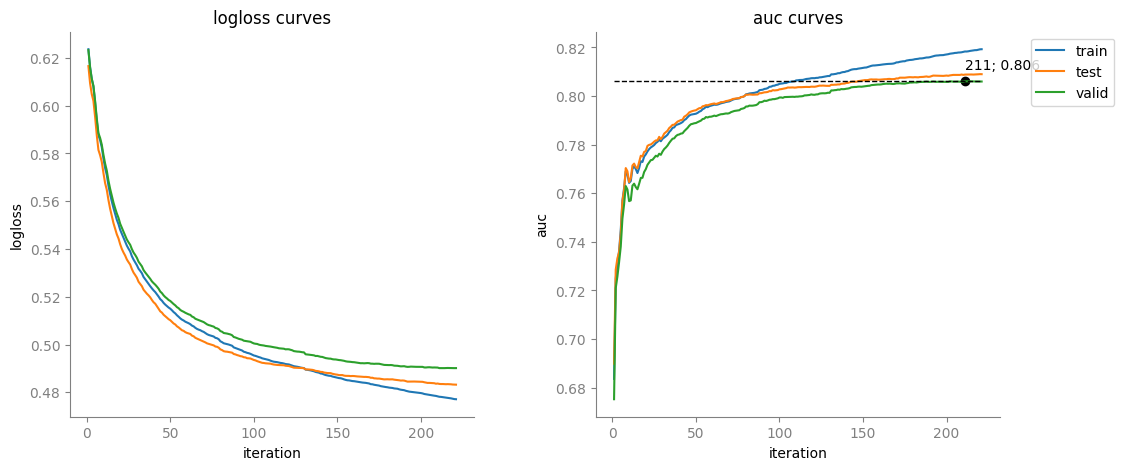

In [38]:
metric = 'logloss'

fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace=0.3)

total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    axs[0].plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

    
for sample, vals in evals_result.items():
    axs[1].plot(
        range(1, total_iteration_count + 1), 
        vals['auc'],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('logloss')
axs[0].set_title(f'logloss curves')

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_color('gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].tick_params(axis='x', colors='gray')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('auc')
axs[1].set_title(f'auc curves')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_color('gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].tick_params(axis='x', colors='gray')

plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

In [74]:
def marginal_dependence(data, predictor, bins, col_target):
    dt = data.copy()
    dt[predictor + 'bin'] = pd.qcut(dt.rank(method='first')[predictor], bins).copy() #pd.qcut(df.rank(method='first'), nbins)
    dt.groupby(predictor + 'bin', observed=False).agg(
        def_prob=(col_target, np.mean)
    ).plot(figsize=(9, 6))

C:\Users\matej\AppData\Local\Temp\ipykernel_45380\3003329733.py:4: FutureWarning: The provided callable <function mean at 0x000001B83FD931C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dt.groupby(predictor + 'bin', observed=False).agg(


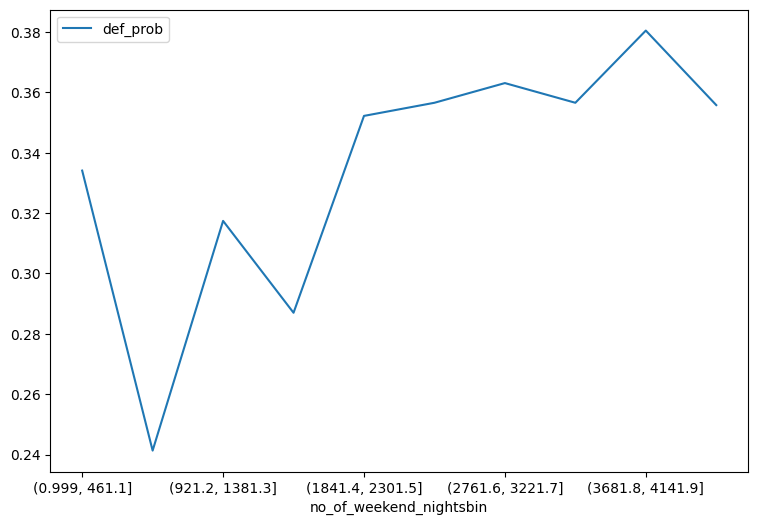

In [75]:
marginal_dependence(data[train_mask], 'no_of_weekend_nights', 10, col_target)